<a href="https://colab.research.google.com/github/Arevalo023/BFOADianaArevaloMejora/blob/main/AnalisisBFOAMejoradoDiana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import numpy
from multiprocessing import Manager

class fastaReader():


    def __init__(self):
        self.path = "/content/multifasta.fasta"

        self.seqs = list()
        self.names = list()
        self.read()


    def read(self):
        f = open(self.path, "r")
        lines = f.readlines()
        f.close()
        seq = ""
        for line in lines:
            if line[0] == ">":
                self.names.append(line[1:].strip())
                if seq != "":
                    self.seqs.append(seq)
                seq = ""
            else:
                seq += line.strip()
        self.seqs.append(seq)

In [45]:
!pip install blosum

In [46]:
import blosum as bl

class evaluadorBlosum():

    def __init__(self):
        matrix = bl.BLOSUM(62)

        self.matrix = matrix

    def showMatrix(self):
        print(self.matrix)

    def getScore(self, A, B):
        #si alguno de los dos es un gap
        if A == "-" or B == "-":
            return -8
        score = self.matrix[A][B]
        return score


    pass

In [47]:
import copy
from multiprocessing import Manager, Pool, managers
from pickle import FALSE, TRUE
#from evaluadorBlosum import evaluadorBlosum
import numpy
#from fastaReader import fastaReader
import random
import math
from copy import copy
import copy
import concurrent.futures


class bacteria():


    def __init__(self, numBacterias):
        # manager = Manager()
        manager = Manager()
        self.blosumScore = manager.list(range(numBacterias))
        self.tablaAtract = manager.list(range(numBacterias))
        self.tablaRepel = manager.list(range(numBacterias))
        self.tablaInteraction = manager.list(range(numBacterias))
        self.tablaFitness = manager.list(range(numBacterias))
        self.granListaPares = manager.list(range(numBacterias))
        self.NFE = manager.list(range(numBacterias))

    def resetListas(self, numBacterias):
        manager = Manager()
        self.blosumScore = manager.list(range(numBacterias))
        self.tablaAtract = manager.list(range(numBacterias))
        self.tablaRepel = manager.list(range(numBacterias))
        self.tablaInteraction = manager.list(range(numBacterias))
        self.tablaFitness = manager.list(range(numBacterias))
        self.granListaPares = manager.list(range(numBacterias))
        self.NFE = manager.list(range(numBacterias))



    def cuadra(self, numSec, poblacion):
        #ciclo para recorrer poblacion
        for i in range(len(poblacion)):
            #obtiene las secuencias de la bacteria
            bacterTmp = poblacion[i]
            # print("bacterTmp: ", bacterTmp)
            bacterTmp = list(bacterTmp)
            # print("bacterTmp: ", bacterTmp)
            bacterTmp = bacterTmp[:numSec]
            # obtiene el tama�o de la secuencia m�s larga
            maxLen = 0
            for j in range(numSec):
                if len(bacterTmp[j]) > maxLen:
                    maxLen = len(bacterTmp[j])
                    #rellena con gaps las secuencias m�s cortas
                    for t in range(numSec):
                        gap_count = maxLen - len(bacterTmp[t])
                        if gap_count > 0:
                            bacterTmp[t].extend(["-"] * gap_count)
                            #actualiza la poblacion
                            poblacion[i] = tuple(bacterTmp)









    """metodo que recorre la matriz y elimina las columnas con gaps en todos los elementos"""
    def limpiaColumnas(self):
        i = 0
        while i < len(self.matrix.seqs[0]):
            if self.gapColumn(i):
                self.deleteCulmn(i)
            else:
                i += 1



        """metodo para eliminar un elemento especifico en cada secuencia"""
    def deleteCulmn(self, pos):
        for i in range(len(self.matrix.seqs)):
            self.matrix.seqs[i] = self.matrix.seqs[i][:pos] + self.matrix.seqs[i][pos+1:]



    """metodo para saber si alguna columna de self.matrix tiene  gap en todos los elementos"""
    def gapColumn(self, col):
        for i in range(len(self.matrix.seqs)):
            if self.matrix.seqs[i][col] != "-":
                return False
        return True



    def creaGranListaPares(self, poblacion):
        # granListaPares = list(range(len(poblacion)))
        #ciclo para recorrer poblacion
        for i in range(len(poblacion)):  #recorre poblacion
            pares = list()
            bacterTmp = poblacion[i]
            bacterTmp = list(bacterTmp)
            #ciclo para recorrer secuencias
            for j in range(len(bacterTmp)):     #recorre secuencias de bacteria
                column = self.getColumn(bacterTmp, j)
                pares = pares + self.obtener_pares_unicos(column)
            self.granListaPares[i] = pares
            # print("Bacteria: ", i, " Pares: ", pares)

        # return self.granListaPares



    def evaluaFila(self, fila, num):
        evaluador = evaluadorBlosum()
        score = 0
        for par in fila:
            score += evaluador.getScore(par[0], par[1])
        self.blosumScore[num] = score

    def evaluaBlosum(self):
        with Pool() as pool:
            args = [(copy.deepcopy(self.granListaPares[i]), i) for i in range(len(self.granListaPares))]
            pool.starmap(self.evaluaFila, args)


    def getColumn(self, bacterTmp, colNum):
        column = []
        #obtiene las secuencias de la bacteria
        # bacterTmp = poblacion[bactNum]
        # bacterTmp = list(bacterTmp)
        #obtiene el caracter de cada secuencia en la columna
        for i in range(len(bacterTmp)):
            column.append(bacterTmp[i][colNum])
        return column





    def obtener_pares_unicos(self, columna):
        pares_unicos = set()
        for i in range(len(columna)):
            for j in range(i+1, len(columna)):
                par = tuple(sorted([columna[i], columna[j]]))
                pares_unicos.add(par)
        return list(pares_unicos)

    #------------------------------------------------------------Atract y Repel lineal




    def compute_diff(self, args):
        indexBacteria, otherBlosumScore, self.blosumScore, d, w = args
        diff = (self.blosumScore[indexBacteria] - otherBlosumScore) ** 2.0
        self.NFE[indexBacteria] += 1
        return d * numpy.exp(w * diff)

    def compute_cell_interaction(self, indexBacteria, d, w, atracTrue):
        with Pool() as pool:
            args = [(indexBacteria, otherBlosumScore, self.blosumScore, d, w) for otherBlosumScore in self.blosumScore]
            results = pool.map(self.compute_diff, args)
            pool.close()  # Close the pool to prevent any more tasks from being submitted
            pool.join()   # Wait for the worker processes to exit

        total = sum(results)

        if atracTrue:
            self.tablaAtract[indexBacteria] = total
        else:
            self.tablaRepel[indexBacteria] = total



    def creaTablaAtract(self, poblacion, d, w):                   #lineal
        for indexBacteria in range(len(poblacion)):
            self.compute_cell_interaction(indexBacteria,d, w, TRUE)
            # print("invocando indexBacteria numero: ", indexBacteria)
        # print("tablaAtract: ", self.tablaAtract)

    def creaTablaRepel(self, poblacion, d, w):                   #lineal
        for indexBacteria in range(len(poblacion)):
            self.compute_cell_interaction(indexBacteria,d, w, FALSE)
            # print("invocando indexBacteria numero: ", indexBacteria)
        # print("tablaAtract: ", self.tablaAtract)

    def creaTablasAtractRepel(self, poblacion, dAttr, wAttr, dRepel, wRepel):
        #invoca ambos metodos en paralelo
        with concurrent.futures.ThreadPoolExecutor() as executor:
            executor.submit(self.creaTablaAtract, poblacion, dAttr, wAttr)
            executor.submit(self.creaTablaRepel, poblacion, dRepel, wRepel)




            #-----------------------------------------------------------

    def creaTablaInteraction(self):
        #llena la tabla con la suma de atract y repel
        for i in range(len(self.tablaAtract)):
            self.tablaInteraction[i] = self.tablaAtract[i] + self.tablaRepel[i]

    def creaTablaFitness(self):
        #llena la tabla con la suma de interaction y blosumScore
        for i in range(len(self.tablaInteraction)):
            valorBlsm = self.blosumScore[i]
            valorInteract = self.tablaInteraction[i]
            #suma ambos valores
            valorFitness =  valorBlsm + valorInteract

            self.tablaFitness[i] = valorFitness

    def getNFE(self):
        return sum(self.NFE)


    def obtieneBest(self, globalNFE):
        bestIdx = 0
        for i in range(len(self.tablaFitness)):
            if self.tablaFitness[i] > self.tablaFitness[bestIdx]:
                bestIdx = i
        print("-------------------   Best: ", bestIdx, " Fitness: ", self.tablaFitness[bestIdx], "BlosumScore ",  self.blosumScore[bestIdx], "Interaction: ", self.tablaInteraction[bestIdx], "NFE: ", globalNFE)
        return bestIdx, self.tablaFitness[bestIdx]

    def replaceWorst(self, poblacion, best):
        worst = 0
        for i in range(len(self.tablaFitness)):
            if self.tablaFitness[i] < self.tablaFitness[worst]:
                worst = i
        # print("Worst: ", worst,  "Blosum ",self.blosumScore[worst], "Fitness: ", self.tablaFitness[worst], "BlosumScore: ", self.blosumScore[worst], "Atract: ", self.tablaAtract[worst], "Repel: ", self.tablaRepel[worst], "Interaction: ", self.tablaInteraction[worst])
        #reemplaza la bacteria peor por una copia de la mejor
        poblacion[worst] = copy.deepcopy(poblacion[best])



In [48]:
import random
import math

def calcular_entropia(columna):
      """Calcula la entropía de una columna (lista de caracteres)."""
      frecuencias = {}
      for simbolo in columna:
          if simbolo not in frecuencias:
            frecuencias[simbolo] = 0
          frecuencias[simbolo] += 1
      entropia = 0
      total = len(columna)
      for frecuencia in frecuencias.values():
          p = frecuencia / total
          entropia -= p * math.log2(p)
      return entropia

def tumbo_mejorado(numSec, poblacion, numGaps):
    #Tumbo inteligente: Inserta gaps donde las secuencias están más desalineadas.
      for i in range(len(poblacion)):
          bacterTmp = list(poblacion[i])

        # Calcular entropía para cada columna
          num_columnas = max(len(seq) for seq in bacterTmp)
          entropias = []

          for col_idx in range(num_columnas):
              columna = []
              for seq in bacterTmp:
                  if col_idx < len(seq):
                      columna.append(seq[col_idx])
                  else:
                      columna.append('-')  # Si una secuencia es más corta, considerar como gap
              entropia = calcular_entropia(columna)
              entropias.append(entropia)

        # Encontrar las columnas de mayor entropía
          columnas_mayor_entropia = sorted(range(len(entropias)), key=lambda k: entropias[k], reverse=True)

        # Insertar gaps priorizando columnas de mayor entropía
          for _ in range(numGaps):
              if columnas_mayor_entropia:
                  col_seleccionada = random.choice(columnas_mayor_entropia[:max(1, len(columnas_mayor_entropia)//3)])  # Top 33% columnas peores
              else:
                  col_seleccionada = random.randint(0, num_columnas-1)

              seqnum = random.randint(0, len(bacterTmp)-1)

            # Insertar un gap en la posición elegida
              if col_seleccionada <= len(bacterTmp[seqnum]):
                  part1 = bacterTmp[seqnum][:col_seleccionada]
                  part2 = bacterTmp[seqnum][col_seleccionada:]
                  bacterTmp[seqnum] = part1 + ['-'] + part2
              else:
                  bacterTmp[seqnum].append('-')

          poblacion[i] = tuple(bacterTmp)



In [49]:
import random

def mutacion_fina(numSec, poblacion, prob_mutacion=0.3):
    """
    Mutación fina: mover o eliminar gaps ligeramente para mejorar el alineamiento.
    :param numSec: número de secuencias
    :param poblacion: lista de bacterias
    :param prob_mutacion: probabilidad de aplicar mutación a cada bacteria
    """
    for i in range(len(poblacion)):
        if random.random() < prob_mutacion:
            bacterTmp = list(poblacion[i])

            # Seleccionamos una secuencia al azar dentro de la bacteria
            seqnum = random.randint(0, len(bacterTmp)-1)
            secuencia = bacterTmp[seqnum]

            if '-' in secuencia:
                # Buscamos todas las posiciones donde hay gaps
                posiciones_gap = [idx for idx, letra in enumerate(secuencia) if letra == '-']
                if posiciones_gap:
                    pos_gap = random.choice(posiciones_gap)

                    # Decidimos mover el gap a izquierda o derecha
                    direccion = random.choice([-1, 1])

                    nueva_pos = pos_gap + direccion

                    # Validar límites
                    if 0 <= nueva_pos < len(secuencia):
                        # Swap: Mover gap
                        secuencia[pos_gap], secuencia[nueva_pos] = secuencia[nueva_pos], secuencia[pos_gap]

            bacterTmp[seqnum] = secuencia
            poblacion[i] = tuple(bacterTmp)


In [50]:
!pip install seaborn

Running iteration 1/30
-------------------   Best:  14  Fitness:  28.5 BlosumScore  13.0 Interaction:  15.5 NFE:  542
-------------------   Best:  13  Fitness:  27.907083869709453 BlosumScore  13.0 Interaction:  14.907083869709455 NFE:  1081
-------------------   Best:  11  Fitness:  25.974677339331606 BlosumScore  13.0 Interaction:  12.974677339331606 NFE:  1621
-------------------   Best:  11  Fitness:  25.5569994876026 BlosumScore  13.0 Interaction:  12.5569994876026 NFE:  2160
-------------------   Best:  11  Fitness:  26.00205675861323 BlosumScore  13.0 Interaction:  13.002056758613227 NFE:  2699
Running iteration 2/30
-------------------   Best:  14  Fitness:  28.63743357685546 BlosumScore  13.0 Interaction:  15.63743357685546 NFE:  549
-------------------   Best:  14  Fitness:  28.65584559074786 BlosumScore  13.0 Interaction:  15.655845590747859 NFE:  1084
-------------------   Best:  14  Fitness:  28.65584559074786 BlosumScore  13.0 Interaction:  15.655845590747859 NFE:  1631
-

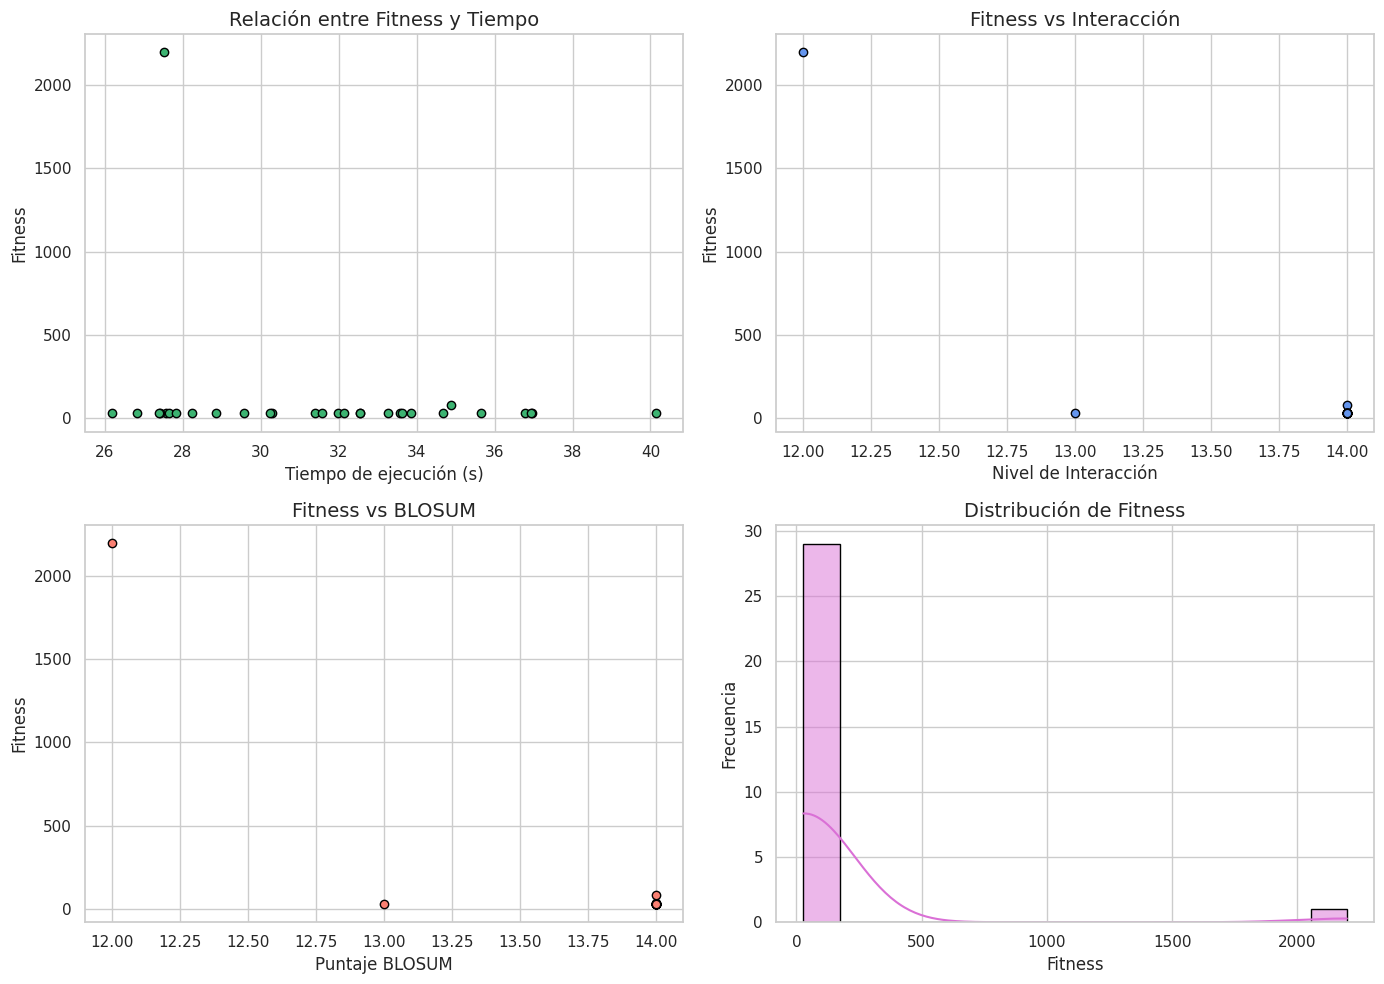

In [51]:
import copy
from multiprocessing import Manager
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def run_algorithm_mejorado(numeroDeBacterias, iteraciones, tumbo_inicial, dAttr, wAttr, hRep, wRep):

    secuencias = fastaReader().seqs
    names = fastaReader().names

    for i in range(len(secuencias)):
        secuencias[i] = list(secuencias[i])

    globalNFE = 0
    manager = Manager()
    numSec = len(secuencias)
    poblacion = manager.list(range(numeroDeBacterias))
    names = manager.list(names)
    NFE = manager.list(range(numeroDeBacterias))

    operadorBacterial = bacteria(numeroDeBacterias)
    veryBest = [None, None, None]

    # --- NUEVO: Variables para control de mejoras ---
    tumbo = tumbo_inicial
    fitness_anterior = None
    elite = []  # Para memoria de élite (opcional)
    max_elite_size = 3

    start_time = time.time()

    def poblacionInicial():
        for i in range(numeroDeBacterias):
            bacterium = []
            for j in range(numSec):
                bacterium.append(secuencias[j])
            poblacion[i] = list(bacterium)

    poblacionInicial()

    for it in range(iteraciones):
        # --- APLICAMOS MEJORA: Tumbo Mejorado ---
        tumbo_mejorado(numSec, poblacion, tumbo)

        operadorBacterial.cuadra(numSec, poblacion)

        # --- APLICAMOS MEJORA: Mutación Fina ---
        mutacion_fina(numSec, poblacion, prob_mutacion=0.3)

        operadorBacterial.creaGranListaPares(poblacion)
        operadorBacterial.evaluaBlosum()
        operadorBacterial.creaTablasAtractRepel(poblacion, dAttr, wAttr, hRep, wRep)
        operadorBacterial.creaTablaInteraction()
        operadorBacterial.creaTablaFitness()
        globalNFE += operadorBacterial.getNFE()

        bestIdx, bestFitness = operadorBacterial.obtieneBest(globalNFE)

        #  Memoria de Élite ---
        if veryBest[0] is None or bestFitness > veryBest[1]:
            veryBest[0] = bestIdx
            veryBest[1] = bestFitness
            veryBest[2] = copy.deepcopy(poblacion[bestIdx])

        if len(elite) < max_elite_size:
            elite.append(copy.deepcopy(poblacion[bestIdx]))
        else:
            worst_idx = min(range(len(elite)), key=lambda i: operadorBacterial.tablaFitness[i])
            if bestFitness > operadorBacterial.tablaFitness[worst_idx]:
                elite[worst_idx] = copy.deepcopy(poblacion[bestIdx])

        if it % 3 == 0 and elite:
            operadorBacterial.replaceWorst(poblacion, 0)

        # Ajuste dinámico del número de Gaps (tumbo dinámico) ---
        fitness_promedio = np.mean(operadorBacterial.tablaFitness)

        if fitness_anterior is not None:
            if fitness_promedio > fitness_anterior:
                tumbo = max(tumbo - 5, 5)
            else:
                tumbo = min(tumbo + 5, 100)

        fitness_anterior = fitness_promedio

        operadorBacterial.replaceWorst(poblacion, veryBest[0])
        operadorBacterial.resetListas(numeroDeBacterias)

    execution_time = time.time() - start_time

    return {
        "fitness": veryBest[1],
        "time": execution_time,
        "interaction": operadorBacterial.tablaInteraction[veryBest[0]],
        "blosum_score": operadorBacterial.blosumScore[veryBest[0]]
    }

def performance_analysis(runs=30):
    results = []
    parameters = {
    "numeroDeBacterias": 15,
    "iteraciones": 5,
    "tumbo_inicial": 50,  # ✅ Cambiado aquí
    "dAttr": 0.1,
    "wAttr": 0.002,
    "hRep": 0.1,
    "wRep": 0.001
}


    # Ejecutar las corridas
    for run in range(runs):
        print(f"Running iteration {run + 1}/{runs}")
        result = run_algorithm_mejorado(**parameters)
        results.append(result)

    df = pd.DataFrame(results)
    df.to_csv("RESULTADOS_BFOA.csv", index=False)
    return df

def plot_results(df):
    sns.set_theme(style="whitegrid")

    plt.figure(figsize=(14, 10))

    # Gráfico 1: Fitness vs Tiempo de ejecución
    plt.subplot(2, 2, 1)
    plt.scatter(df['time'], df['fitness'], color='mediumseagreen', edgecolors='black')
    plt.xlabel('Tiempo de ejecución (s)', fontsize=12)
    plt.ylabel('Fitness', fontsize=12)
    plt.title('Relación entre Fitness y Tiempo', fontsize=14)
    plt.grid(True)

    # Gráfico 2: Fitness vs Interacción
    plt.subplot(2, 2, 2)
    plt.scatter(df['interaction'], df['fitness'], color='cornflowerblue', edgecolors='black')
    plt.xlabel('Nivel de Interacción', fontsize=12)
    plt.ylabel('Fitness', fontsize=12)
    plt.title('Fitness vs Interacción', fontsize=14)
    plt.grid(True)

    # Gráfico 3: Fitness vs BLOSUM Score
    plt.subplot(2, 2, 3)
    plt.scatter(df['blosum_score'], df['fitness'], color='salmon', edgecolors='black')
    plt.xlabel('Puntaje BLOSUM', fontsize=12)
    plt.ylabel('Fitness', fontsize=12)
    plt.title('Fitness vs BLOSUM', fontsize=14)
    plt.grid(True)

    # Gráfico 4: Histograma de Fitness
    plt.subplot(2, 2, 4)
    sns.histplot(df['fitness'], bins=15, kde=True, color='orchid', edgecolor='black')
    plt.xlabel('Fitness', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.title('Distribución de Fitness', fontsize=14)
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("GRAFICAS_BFOA.png", dpi=300)
    plt.show()

if __name__ == "__main__":
    # Ejecutar el análisis de desempeño con 30 corridas
    df = performance_analysis(runs=30)

    plot_results(df)